# 1. PyMuPDF

In [2]:
! pip install pymupdf pillow

In [4]:
!pip uninstall fitz


^C


In [ ]:
!pip install PyMuPDF

In [ ]:
! import fitz
print(fitz.__doc__)


In [3]:
# import fitz  # PyMuPDF
import pymupdf 
import io
from PIL import Image

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Open the PDF file
pdf_document = pymupdf.open('../../Data/pdfs_for_Vanilla_RAG/2408.08521v1.pdf')

In [6]:
import fitz  # PyMuPDF
from PIL import Image
import io
import matplotlib.pyplot as plt

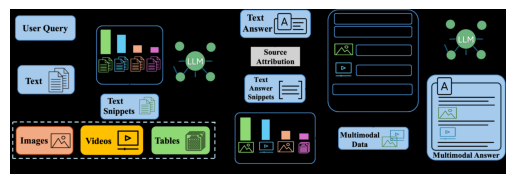

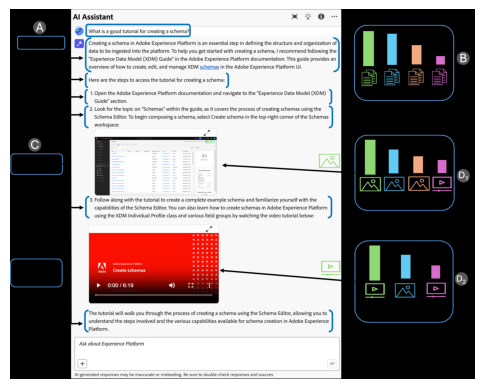

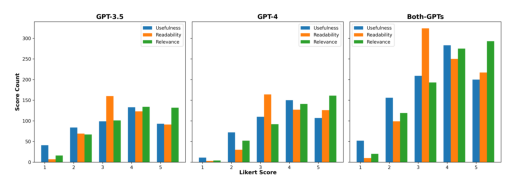

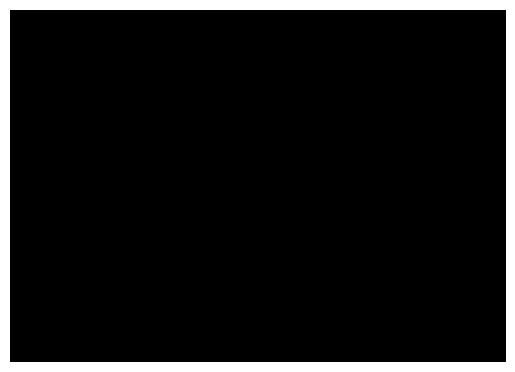

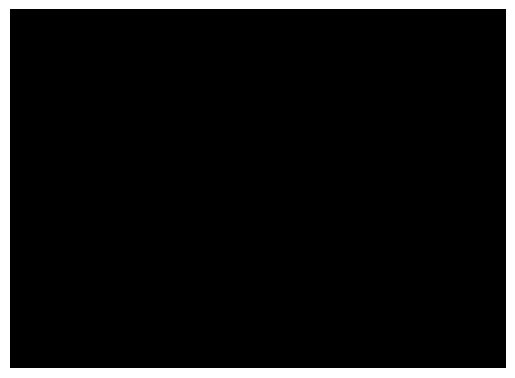

In [15]:
for page_number in range(len(pdf_document)):
    page = pdf_document[page_number]
    image_list = page.get_images(full=True)
    
    for image_index, img in enumerate(image_list, start=1):
        xref = img[0]

        # Create a pixmap (rendered image)
        pix = fitz.Pixmap(pdf_document, xref)

        # If image has alpha channel (n > 4), convert to RGB
        if pix.n > 4:
            pix = fitz.Pixmap(fitz.csRGB, pix)

        # Save to PNG bytes
        image_bytes = pix.tobytes("png")

        # Open with PIL
        image = Image.open(io.BytesIO(image_bytes))
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        
        # Save image
        # image.save(f"page{page_number+1}_image{image_index}.{image_ext}")


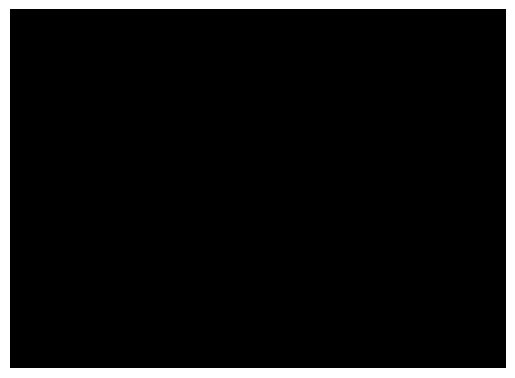

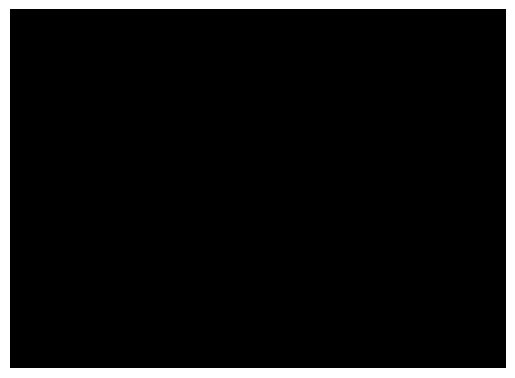

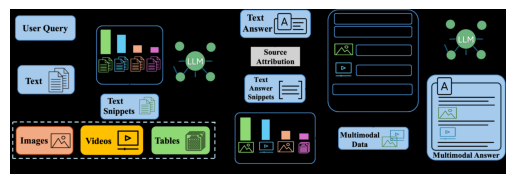

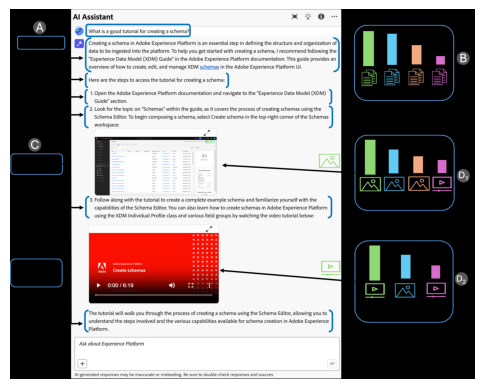

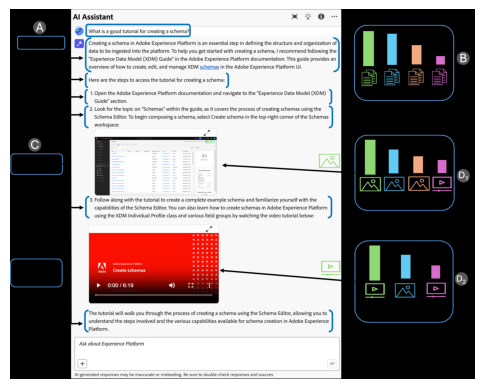

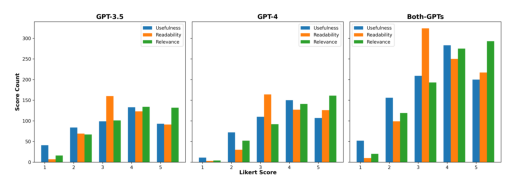

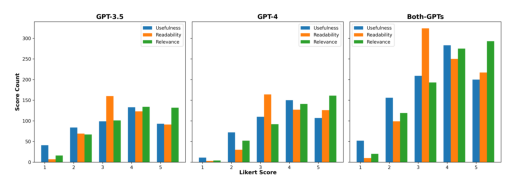

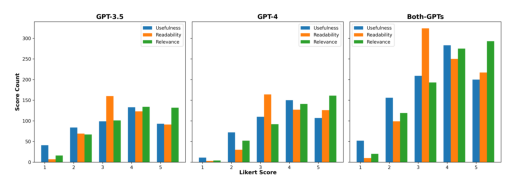

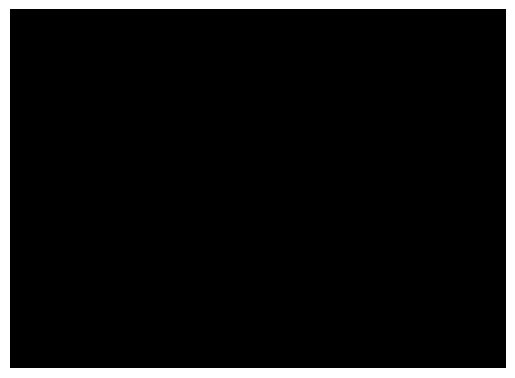

In [16]:
for page_number in range(len(pdf_document)):
    page = pdf_document[page_number]
    image_list = page.get_images(full=True)
    
    for image_index, img in enumerate(image_list, start=1):
        xref = img[0]
    pix = fitz.Pixmap(pdf_document, xref)

    # If image has alpha channel (n > 4), convert to RGB
    if pix.n > 4:
        pix = fitz.Pixmap(fitz.csRGB, pix)

    # Save to PNG bytes
    image_bytes = pix.tobytes("png")

    # Open with PIL
    image = Image.open(io.BytesIO(image_bytes))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


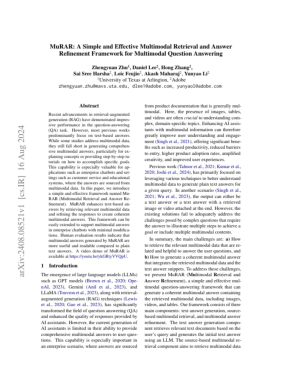

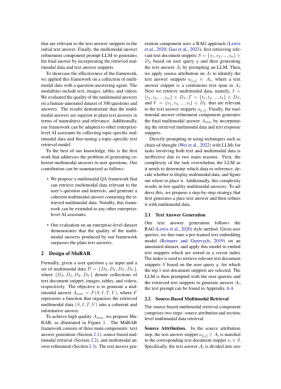

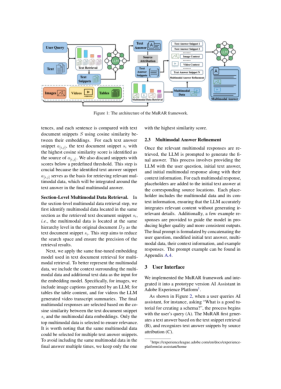

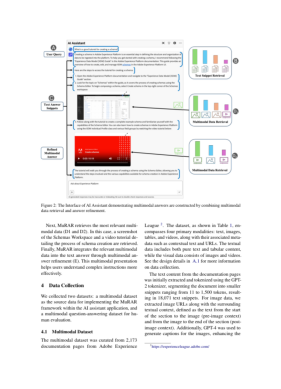

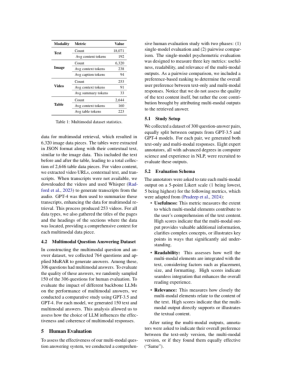

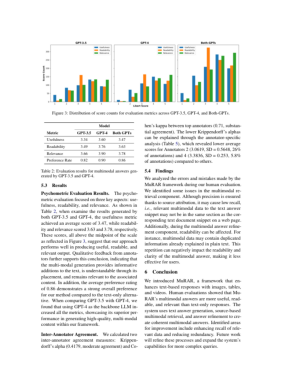

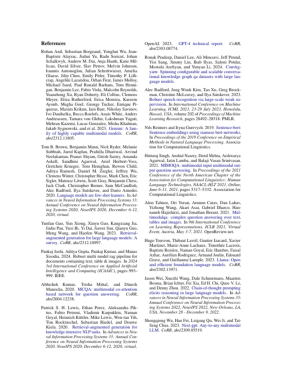

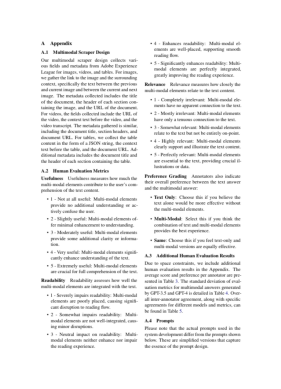

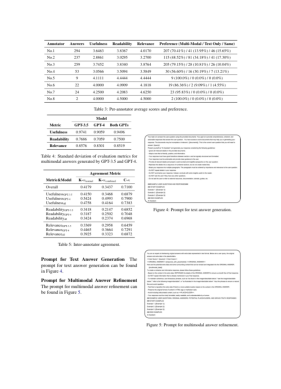

In [17]:
for page_number in range(len(pdf_document)):
    page = pdf_document[page_number]
    image_list = page.get_images(full=True)
    
    for image_index, img in enumerate(image_list, start=1):
        xref = img[0]
    pix = page.get_pixmap(alpha=False)  # alpha=True if you want transparency
    image_bytes = pix.tobytes("png")
    image = Image.open(io.BytesIO(image_bytes))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


---

# Detect and crop the images

In [8]:
import fitz  # PyMuPDF
import cv2
import numpy as np
from PIL import Image
import io
import os

def detect_and_crop_images(pdf_path, output_dir, dpi=150):
    os.makedirs(output_dir, exist_ok=True)
    doc = fitz.open(pdf_path)

    for page_number in range(len(doc)):
        page = doc[page_number]
        pix = page.get_pixmap(dpi=dpi)
        image = Image.open(io.BytesIO(pix.tobytes("png")))

        # Convert PIL image to OpenCV format
        open_cv_image = np.array(image.convert("RGB"))
        gray = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)

        # Threshold + contour detection
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        image_index = 0
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)

            # Filter out small elements (like text or noise)
            if w < 100 or h < 100:
                continue

            # Optional: skip wide lines that are likely text blocks
            if w > 0.9 * pix.width or h > 0.9 * pix.height:
                continue

            # Crop and save
            cropped = image.crop((x, y, x + w, y + h))
            image_index += 1
            
            plt.imshow(cropped)
            plt.axis("off")
            plt.show()
            
            cropped.save(os.path.join(output_dir, f"page_{page_number+1}_img_{image_index}.png"))

        print(f"Page {page_number+1}: Saved {image_index} cropped image(s)")

    doc.close()


Page 1: Saved 0 cropped image(s)
Page 2: Saved 0 cropped image(s)


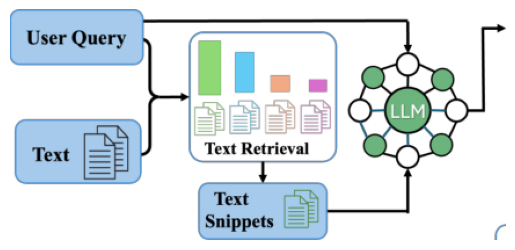

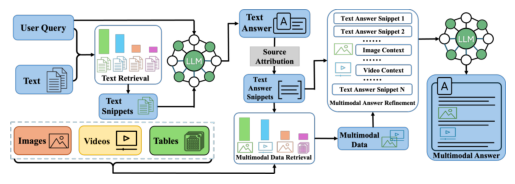

Page 3: Saved 2 cropped image(s)


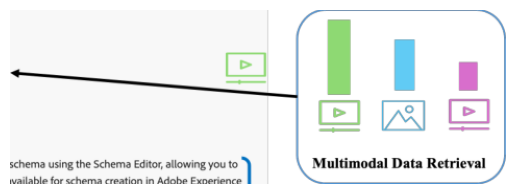

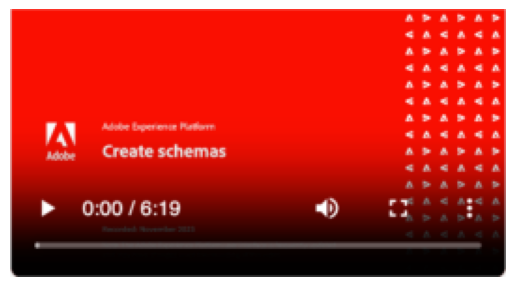

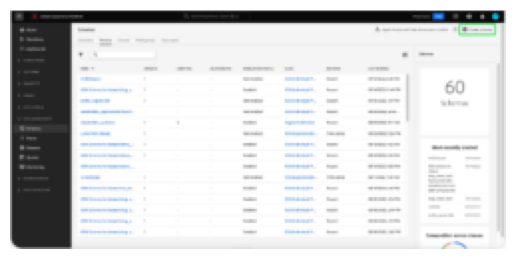

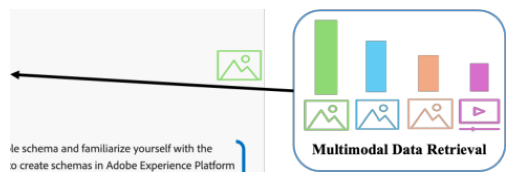

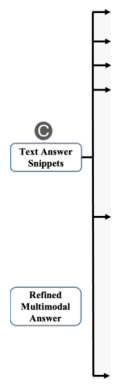

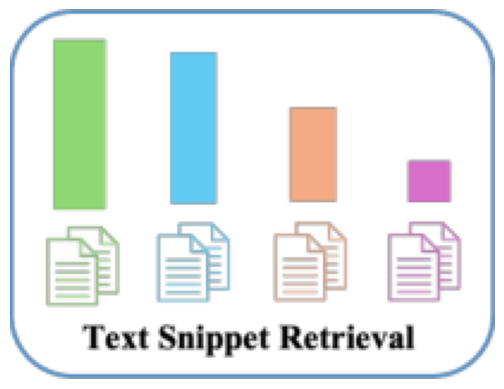

Page 4: Saved 6 cropped image(s)
Page 5: Saved 0 cropped image(s)


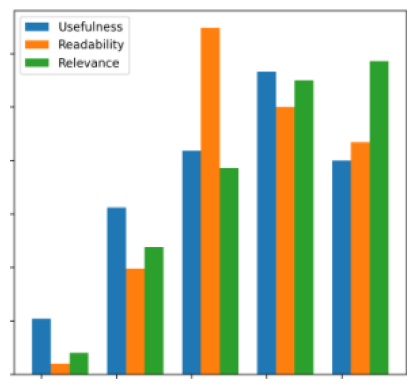

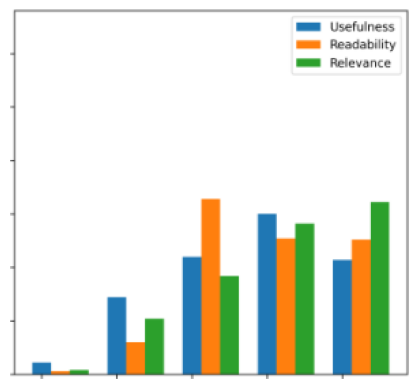

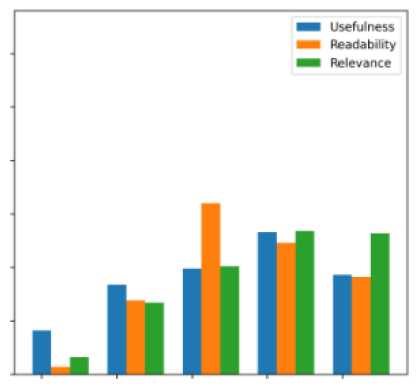

Page 6: Saved 3 cropped image(s)
Page 7: Saved 0 cropped image(s)
Page 8: Saved 0 cropped image(s)


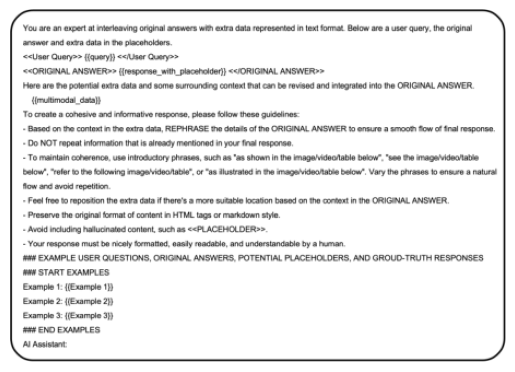

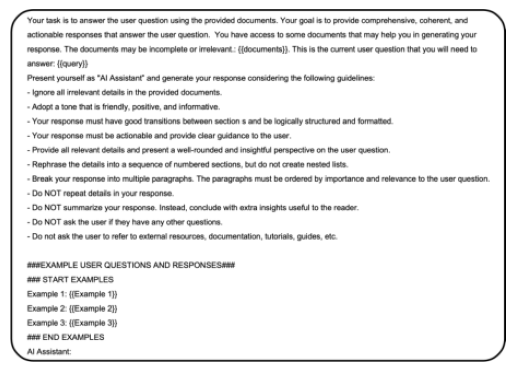

Page 9: Saved 2 cropped image(s)


In [9]:
detect_and_crop_images(pdf_document, '.', dpi=150)

In [11]:
def is_image_like(w, h, area_ratio, page_width, page_height):
    if w < 100 or h < 100:
        return False
    if w > 0.95 * page_width or h > 0.95 * page_height:
        return False
    if area_ratio < 0.5:  # Shape is much smaller than its bounding box (i.e., not a solid image)
        return False
    return True

def detect_and_crop_images_v2(pdf_path, output_dir, dpi=150):
    os.makedirs(output_dir, exist_ok=True)
    doc = fitz.open(pdf_path)

    for page_number in range(len(doc)):
        page = doc[page_number]
        pix = page.get_pixmap(dpi=dpi)
        image = Image.open(io.BytesIO(pix.tobytes("png")))

        # Convert to OpenCV format
        open_cv_image = np.array(image.convert("RGB"))
        gray = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)

        # Threshold for strong edges
        _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

        # Find contours *with hierarchy*
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)


---

## Get image from the internal refernce name

In [13]:
doc = fitz.open(pdf_document)

for page_number in range(len(doc)):
    page = doc[page_number]
        
    for img in page.get_images(full=True):
        print("Image Name:", img[7])


Image Name: Im1
Image Name: Im2
Image Name: Im3
Image Name: Im4
Image Name: Im5


In [14]:
import fitz  # PyMuPDF
from PIL import Image
import io

def extract_image_by_pdf_name(pdf_path, image_name):
    doc = fitz.open(pdf_path)

    for page_number in range(len(doc)):
        page = doc[page_number]
        images = page.get_images(full=True)

        for img in images:
            xref = img[0]
            name_in_pdf = img[7]  # This is typically something like /Im1

            if name_in_pdf == image_name:
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]
                image = Image.open(io.BytesIO(image_bytes))
                print(f"✅ Found '{image_name}' on page {page_number+1}")
                return image

    print(f"❌ Image '{image_name}' not found in '{pdf_path}'")
    return None


In [15]:
img = extract_image_by_pdf_name(pdf_document, "Im5")

if img:
    img.show()  # or img.save("output.png")


✅ Found 'Im5' on page 9


In [34]:
pymupdf.version

('1.25.5', '1.25.6', '20250331000001')

In [21]:
# Example using PyMuPDF
import fitz  # PyMuPDF

doc = fitz.open(pdf_document)
for page_index in range(len(doc)):
    page = doc[page_index]
    image_list = page.get_images(full=True)
    
    for img_index, img in enumerate(image_list):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        
            
        with open(f"page{page_index+1}_img{img_index+1}.{image_ext}", "wb") as f:
            f.write(image_bytes)


## Using ML model

In [ ]:
from layoutparser import Detectron2LayoutModel

model = Detectron2LayoutModel(
    config_path="lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config",
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

layout = model.detect("page_1.png")

for i, block in enumerate(layout):
    if block.type == "Figure":
        x1, y1, x2, y2 = map(int, block.coordinates)
        segment = img[y1:y2, x1:x2]
        cv2.imwrite(f"figure_{i+1}.png", segment)
